## 4-2.  Quantum simulation using Trotter decomposition
In this section, we introduce one method for simulating the dynamics of quantum systems: dynamics simulation based on Trotter decomposition. This method is in a sense the most straightforward method for simulating dynamics, and it works on NISQ devices up to a certain scale of problems.   
Here we try to simulate the quantum dynamics of a physical system, and we focus on the 1D transverse field Ising model.

### Trotter decomposition

The Trotter decomposition is a formula that approximates the exponential function of the sum of square matrices $A,B$ to the product of their respective exponential functions

$$
e^{\delta (A+B)} = e^{\delta A} \cdot e^{\delta B} +  O\left( \delta^2 \right).
$$

$O$ is the order notation introduced in the [Section 2.3](2.3_quantum_Fourier_transform.ipynb) column, which represents the approximate accuracy of the approximation. (Note that $e^{A+B}\neq e^A\cdot e^B$ since $A,B$ are matrices that don't necessarily commute).

### Quantum simulation using Trotter decomposition

As we learned in the previous section, the time evolution of a quantum state follows the Schrodinger equation $i\frac{\partial}{\partial t}|\psi(t)\rangle = H|\psi(t)\rangle$ (assuming $\hbar=1$). In particular, if the Hamiltonian $H$ is independent of time, the state after time $t$ is $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$ ($|\psi(0)\rangle$ is the initial state). In other words, in simulating the dynamics of a quantum system, it is enough to calculate the operator $e^{-iHt}$. However, in an $n$-qubit system, $H$ is a $2^n$-dimensional, i.e very large, matrix. Therefore, it is difficult to compute this exponential function with a classical computer, and it is also considered difficult to compute the exponential function of any $2^n$-dimensional matrix $H$ with a quantum computer.

However, if the Hamiltonian has a **specific structure**, a quantum computer can compute $e^{-iHt}$ efficiently. The Trotter decomposition is used for this purpose.   
Let us consider a concrete example. Consider an Ising model consisting of $n$ qubits (see below). The Hamiltonian for this model is given by $H = \sum_{i=1}^{n-1} Z_i Z_{i+1}$. Using the Trotter decomposition, we can decompose $e^{-iH t}$ as

$$
 e^{-iHt} = e^{-i\left(\sum_{i=1}^{n-1} Z_i Z_{i+1}\right) t} = \left(e^{-i(Z_1 Z_2 + Z_2 Z_3 \cdots )\frac{t}{M}}\right)^M
 \approx \left(e^{-i(Z_1 Z_2)\frac{t}{M}}\cdot e^{-i(Z_2 Z_3)\frac{t}{M}}\cdot\cdots \right)^M  \tag{1}
$$

Let $M$ be the total number dividing the action of $e^{-iHt}$, chosen so that the accuracy of the approximation $O\left((t/M)^2\right)$ is enough.   
If we look at the last equation, we see that we need to perform $nM$ products of $e^{-i(Z_i Z_{i+1})\frac{t}{M}}$, which is a small matrix (2 qubit gates, 4 dimensions). In other words, **the action of an exponentially large matrix could be written as polynomial products of small matrices (2 qubit gates)**.

Thus, if the Hamiltonian can be written as a sum of a small number of terms, it can be computed at high speed on a quantum computer using the Trotter decomposition.

*Incidentally, most Hamiltonians of interest in physics and quantum chemistry have a form that allows efficient Trotter decomposition.


### Implementation of quantum dynamics (1): Ising model

Let us consider the Ising model as a concrete system to implement quantum simulation.   
(For readers who are not familiar with physics, we will introduce the necessary concepts needed to follow the calculation.)

The property of matter to respond to a magnetic field is called magnetism, and in the microscopic world, electrons and atomic nuclei have very small magnetic properties, called **spin**. Roughly speaking, we can think of spin as a small magnet. The magnets we see in everyday life are the result of the neat alignment of the small magnetism exhibited by the spins of the electrons (and atomic nuclei) in matter.

The Ising model is a model that describes the behavior of the spins in matter and was invented as a model that extracts the essence of magnets. The definition is as follows:

$$
H = J \sum_{i=1}^{n} Z_i Z_{i+1}
$$

where $J$ is a parameter of the model that determines the strength of the interaction between the spins, $n$ is the number of particles with spin, and $Z_i$ is the $z$-axis component of the spin of the $i$-th particle. As we learned in the previous section, physical quantities are represented by Hermitian operators called observables, so the magnetization (strength of the magnetic force) exhibited by spins is also represented by an operator. Using the $x,y,z$ (Cartesian) coordinate system, the magnetization can be written in terms of the Pauli operators are $X,Y,Z$.
By convention we use the z-direction as the quantization axes which means that $Z|0\rangle=|0\rangle$, $Z|1\rangle= -|1\rangle$. In other words, the state $|0\rangle$ corresponds to the spin facing $+z$ direction and the $|1\rangle$ corresponds to the spin facing the $-z$ direction. In what follow we will consider tha that each spin is represented by a qubit. So the $i^{th}$ spin = $i^{th}$ qubit. 

The product $Z_i Z_{i+1}$ in this model represent the interaction between neighboring qubits. When $J>0$, $Z_i Z_{i+1}=1$ for $(Z_i,Z_{i+1})=(1,1),(-1,-1)$ and $Z_i Z_{i+1}=-1$ for $(Z_i,Z_{i+1})=(1,-1),(-1,1)$, so the energy is low when the spins point in opposite directions, e.g. $| 010101\cdots\rangle$. Conversely, for $J<0$, the spin-aligned cases $|000\cdots\rangle$ and $|111\cdots\rangle$ have the lowest energy, and the system behaves as a magnet with a large magnetization.

This model can be easily solved without using a quantum computer, but we will use this model as for a first implementation of the Trotter decomposition. The Trotter decomposition of $e^{-iHt}$ is derived in equation (1) but what we need is how to implement the gate $e^{-i \delta Z_i Z_{i+1}}$. This can be done as follows (we leave the mathematical verification as an exercise):
$$
e^{-i \delta Z_i Z_{i+1}} = \operatorname{CNOT}_{i,i+1} \cdot e^{-i\delta Z_{i+1}} \cdot \operatorname{CNOT}_{i,i+1}.
$$

Now, we focus on the physical quantity corresponding to the total magnetization in the z-direction 

$$
\left\langle\psi\left|\sum_{i=1}^{n} Z_i\right|\psi\right\rangle
$$

and follow its time variation.

**The initial state is $|000\cdots\rangle$ with spin aligned in the** $+z$ direction, and for convenience, $Z_{n+1}$ is identified with $Z_1$, assuming that the system is periodic.

In [1]:
from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix
from quri_parts.core.state import quantum_state
from quri_parts.circuit import QuantumCircuit
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
import matplotlib.pyplot as plt
import numpy as np

### Implementation of quantum dynamics (1): Ising model

In this section, we will be using QURI Parts to perform the simulation. Please check out the [QURI Parts documentation page](https://quri-parts.qunasys.com/) first for tutorials on how to perform [expectation value estimation](https://quri-parts.qunasys.com/tutorials/estimator_basics) and [construct quantum circuits](https://quri-parts.qunasys.com/tutorials/circuits) with QURI Parts.

Here, we consider a system with six particles, which corresponds to six qubits in this case. Then, we simulate the system over 1 second with 

In [2]:
n_qubits = 6
# Time to simulate dynamics
t = 1.0
# Number of divisions of Trotter decomposition
M = 100
# Time increment range
delta = t/M

The observable which we want to evaluate its expectation value is the magnetization given by:

$$M = \frac{1}{6}\sum_{i=1}^{6}Z_{i}$$

In [3]:
## Prepare observable for all magnetizations.
magnetization_obs = Operator(
    {
        pauli_label(f"Z{i}"): 1/n_qubits
        for i in range(n_qubits)
    } 
)
for op, coeff in magnetization_obs.items():
    print(f"{round(coeff, 8)} * {op}")

0.16666667 * Z0
0.16666667 * Z1
0.16666667 * Z2
0.16666667 * Z3
0.16666667 * Z4
0.16666667 * Z5


Then, we prepare the initial state $|000000\rangle$

In [4]:
state = quantum_state(n_qubits)

Next we construct the time evolution operator with a quantum circuit. In this tutorial, we build it by converting the one Trotter decomposition Hamiltonian 
$$e^{iZ_1Z_2\delta}e^{iZ_2Z_3\delta}...e^{iZ_nZ_1\delta}$$
into a quantum circuit and apply it to the initial state repeatedly.

In [5]:
circuit_trotter_Ising = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    circuit_trotter_Ising.add_CNOT_gate(i, (i+1)%n_qubits)
    circuit_trotter_Ising.add_RZ_gate((i+1)%n_qubits, -2*delta)  # Note that the RZ gate is given by exp(-i *delta / 2) in QURI Parts
    circuit_trotter_Ising.add_CNOT_gate(i, (i+1)%n_qubits)

We are now ready to simulate the system's time evolution

/Users/daniel/anaconda3/envs/qp_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


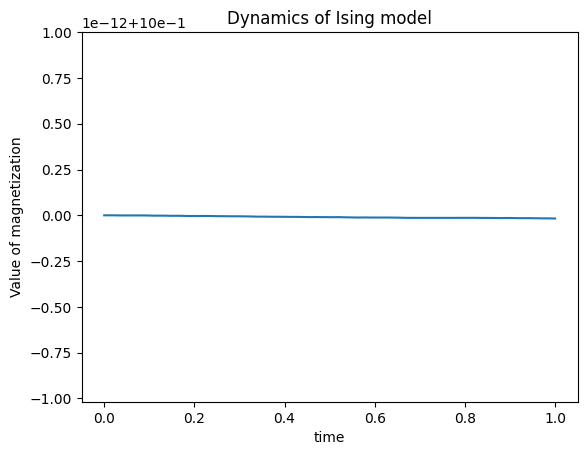

In [6]:
from quri_parts.core.state import apply_circuit

# An estimator needs to be created for expectation value estimation
estimator = create_qulacs_vector_estimator()

# A list that records time and magnetization
x = [i*delta for i in range(M+1)]
y = []


#Calculate total magnetization at t=0
y.append(estimator(magnetization_obs, state).value)


#Calculate total magnetization after t=0
for i in range(M):
    # Time evolution by delta=t/M
    circuit = QuantumCircuit(
        state.qubit_count, gates=circuit_trotter_Ising.gates * (i+1)
    )
    state_i = apply_circuit(circuit, state)
    # Calculate and record magnetization
    y.append(estimator(magnetization_obs, state_i).value)


#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of Ising model")
plt.plot(x, y, "-")
plt.show()

As can be seen in this result, the total magnetization in the $z$ direction is constant (also note the scale of the vertical axis).
In fact, since the Ising model only interacts in the $z$ direction, the magnetization in the $z$ direction is also conserved. This is not interesting, so let us now look at the time evolution of the transverse magnetic field Ising model with a magnetic field in the $x$  direction.

### Implementation of Quantum Dynamics (2): Transverse Magnetic Field Ising Model

Let's consider a transverse magnetic field Ising model with a uniform magnetic field along the $x$ axis applied to the Ising model.

$$
H = \sum_{i=1}^n Z_i Z_{i+1} + h\sum_{i=1}^n X_i  
$$ 

The $h$ is a coefficient representing the strength of the transverse magnetic field, and $X_i$ is the Pauli operator (observable) representing the magnetization of the $i$th particle in the $x$ direction.

If we perform the Trotter decomposition in this model, we will add the term $e^{-ih X_1 \frac{t}{M}} \cdots e^{-ih X_n \frac{t}{M}}$ in addition to the Ising model described earlier.   
Now let's actually look at the total magnetization in this model.

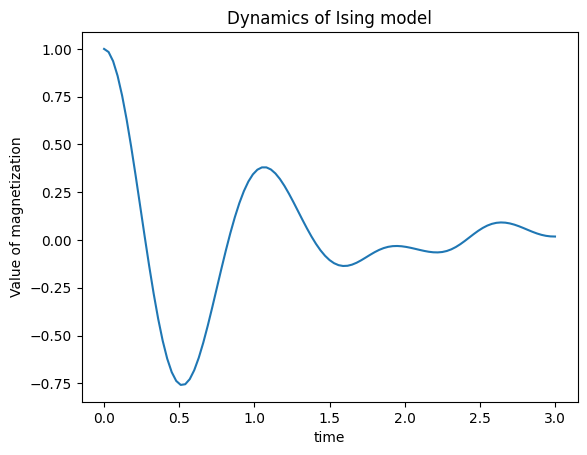

In [7]:
# In this case, we consider a system with six particles.
n_qubits = 6
#  Time to simulate dynamics
t = 3.0
# Number of divisions of Trotter decomposition
M = 100
# Time increment range
delta = t/M
## Transverse magnetic field strength
h = 3.

## Prepare observable for all magnetizations.
magnetization_obs = Operator(
    {
        pauli_label(f"Z{i}"): 1/n_qubits
        for i in range(n_qubits)
    } 
)

## The initial state is |000000>
state = quantum_state(n_qubits)

# Convert one Trotter decomposition ,e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} to a quantum gate
circuit_trotter_Ising = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    circuit_trotter_Ising.add_CNOT_gate(i, (i+1)%n_qubits)
    circuit_trotter_Ising.add_RZ_gate((i+1)%n_qubits, -2*delta)  # Note that the RZ gate is given by exp(-i *delta / 2) in QURI Parts
    circuit_trotter_Ising.add_CNOT_gate(i, (i+1)%n_qubits)
    circuit_trotter_Ising.add_RX_gate(i, -2*delta*h)


## A list that records time and magnetization
x = [i*delta for i in range(M+1)]
y = []


#Calculate total magnetization at t=0
estimator = create_qulacs_vector_estimator()
y.append(estimator(magnetization_obs, state).value.real)


#Calculate total magnetization after t=0
for i in range(M):
    # Time evolution by delta=t/M
    circuit = QuantumCircuit(state.qubit_count, gates=circuit_trotter_Ising.gates * (i+1))
    state_i = apply_circuit(circuit, state)
    # Calculate and record magnetization
    y.append(estimator(magnetization_obs, state_i).value.real)


#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of Ising model")
plt.plot(x, y, "-")
plt.show()

The Ising model with $h=0$ has a constant total magnetization, whereas the transverse field Ising model with a transverse magnetic field of $h=3$ has a significant difference in that the value of total magnetization changes over time and even drops to a negative value. 
This can be thought of as the transverse magnetic field (magnetic field in the $x$ direction) causing the spins that were aligned in the $z$ direction to become disorganized and disordered, resulting in a change in the value of total magnetization. If you are interested, try to calculate with a stronger $h$ value, and you will see that the speed of magnetization decrease becomes faster.

### Implementation of quantum dynamics (3): Comparison with exact solution

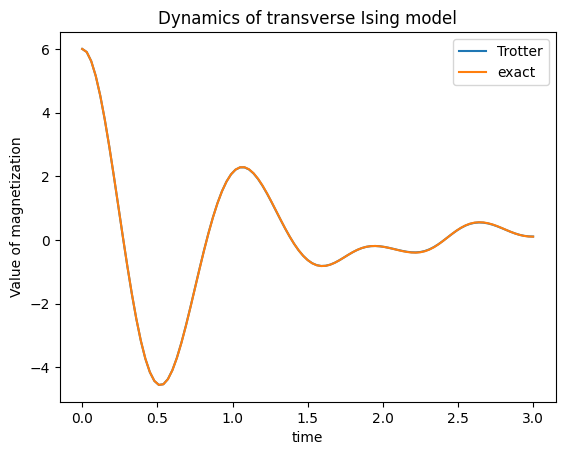

In [8]:
from scipy.linalg import expm
from quri_parts.core.state import CircuitQuantumState

# In this case, we consider a system with six particles.
n_qubits = 6
#  Time to simulate dynamics
t = 3.0
# Number of divisions of Trotter decomposition
M = 100
# Time increment range
delta = t/M

# Transverse magnetic field strength
h = 3.

## Prepare observable for all magnetizations.
magnetization_obs = Operator(
    {
        pauli_label(f"Z{i}"): 1
        for i in range(n_qubits)
    } 
)

# Prepare expectation value estimator
estimator = create_qulacs_vector_estimator()

def get_trotter_time_evolution_circuit() -> QuantumCircuit:
    """Convert one Trotter decomposition:
        
        e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta}
    
    to a quantum gate
    """
    circuit_trotter_Ising = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        circuit_trotter_Ising.add_CNOT_gate(i, (i+1)%n_qubits)
        # Note that the RZ gate is given by exp(-i *delta / 2) in QURI Parts
        circuit_trotter_Ising.add_RZ_gate((i+1)%n_qubits, -2*delta)
        circuit_trotter_Ising.add_CNOT_gate(i, (i+1)%n_qubits)
        circuit_trotter_Ising.add_RX_gate(i, -2*delta*h)
    return circuit_trotter_Ising

def get_exact_time_evolution_circuit() -> QuantumCircuit:
    """Build hamiltonian and the exact time evolution circuit
    """

    # Build Hamiltonian
    hamiltonian = Operator()
    for i in range(n_qubits):
        hamiltonian.add_term(pauli_label(f"Z{i} Z{(i+1)%n_qubits}"), 1)
        hamiltonian.add_term(pauli_label(f"X{i}"), h)
    hamiltonian_matrix = get_sparse_matrix(hamiltonian).toarray()

    # Exact time evolution circuit
    exp_h = expm(-1j * hamiltonian_matrix * delta)
    circuit_exact_Ising = QuantumCircuit(n_qubits)
    circuit_exact_Ising.add_UnitaryMatrix_gate(range(n_qubits), exp_h)

    return circuit_exact_Ising

def run_time_evolution(
    initial_state: CircuitQuantumState,
    trotter_time_evo_circuit: QuantumCircuit,
    exact_time_evo_circuit: QuantumCircuit,
) -> tuple[list[float], list[float]]:
    """Run both Trotter and exact time evolution
    """

    # A list that records time and magnetization
    y_trotter = []
    y_exact = []

    #Calculate total magnetization at t=0
    y_trotter.append(estimator(magnetization_obs, initial_state).value.real)
    y_exact.append(estimator(magnetization_obs, initial_state).value.real)

    #Calculate total magnetization after t=0
    n_qubits = init_state.qubit_count
    for i in range(M):
        # Time evolution by delta=t/M
        exact_circuit_i = QuantumCircuit(n_qubits, exact_time_evo_circuit.gates * (i+1))
        exact_state_i = apply_circuit(exact_circuit_i, initial_state)

        trotter_circuit_i = QuantumCircuit(n_qubits, trotter_time_evo_circuit.gates * (i+1))
        trotter_state_i = apply_circuit(trotter_circuit_i, initial_state)
        
        # Calculate and record magnetization
        y_exact.append(estimator(magnetization_obs, exact_state_i).value.real)
        y_trotter.append(estimator(magnetization_obs, trotter_state_i).value.real)
    
    return y_trotter, y_exact

## Intitial state set to be |000000>
init_state = quantum_state(n_qubits)
circuit_exact_Ising = get_exact_time_evolution_circuit()
circuit_trotter_Ising = get_trotter_time_evolution_circuit()

y_trotter, y_exact = run_time_evolution(init_state, circuit_trotter_Ising, circuit_exact_Ising)

x = [i*delta for i in range(M+1)]
#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y_trotter, "-", label="Trotter")
plt.plot(x, y_exact, "-", label="exact")
plt.legend()
plt.show()

In this range, it seems that they are almost the same. Let's look at the error.

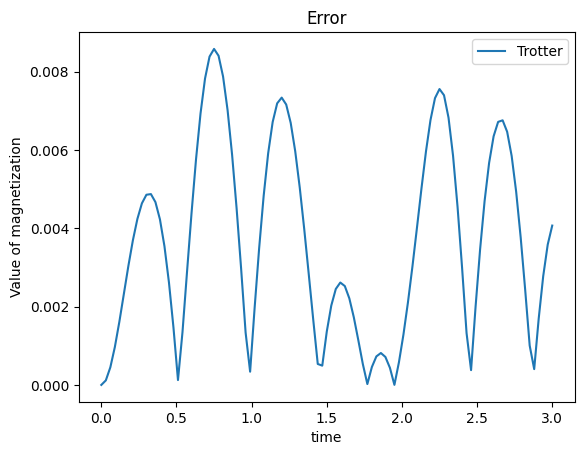

In [9]:
#Drawing a graph
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Error")
plt.plot(x, np.abs(np.array(y_trotter) - np.array(y_exact)), "-", label="Trotter")
plt.legend()
plt.show()

We recommend interested readers to decrease division numbers $M$ and increase time $t$.